In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from TCC import model_util
from TCC.models.unet import build
from TCC.models.unet_v2 import unet_v2_get_model
from model_util import load_all_imgs, Saver, ImgTesterV2, test_v2
from model_util import model_path

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [7]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = (128, 128)
epochs = 30
batch_size= 4
num_classes = 3
validation_split= 0.2
f = [64, 128]

threshold = 0.5
metric_name = "mean_iou_threshold"
metric = tf.keras.metrics.MeanIoU(num_classes=2, name=metric_name)

base_output_path = '..\\imagens_cra\\result\\unet_multiclass_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation_interna_externa_v2/cra"


In [8]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)

y_imgs = load_all_imgs(y_dir,image_size, 0)
y_imgs = y_imgs * 255.0


validImgs = np.zeros(y_imgs.shape + (3, ) )

validImgs[y_imgs == 0] = np.array([1, 0, 0])
validImgs[y_imgs == 1] = np.array([0, 1, 0])
validImgs[y_imgs == 2] = np.array([0, 0, 1])


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation_interna_externa_v2/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

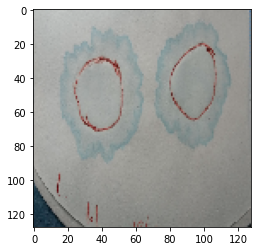

In [9]:
plt.imshow(trainImgs[0])

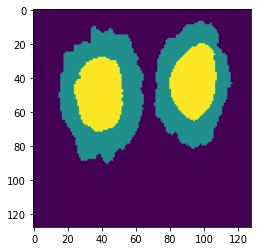

In [10]:
plt.imshow(y_imgs[0])

In [11]:

def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

model = unet_v2_get_model(image_size, 3, filters=f)
model.compile(run_eagerly=True,optimizer="rmsprop", loss="categorical_crossentropy", metrics=mean_iou_threshold)
model.summary()

down_sampling_filters: [64, 128]
up_sampling_filters: [128, 64, 32]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 64, 64, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 64, 64, 32)   0           batch_normalization_11[0][0]     
________________________

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path(base_output_path), save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
history = model.fit(trainImgs, validImgs,
          epochs=epochs, callbacks=callbacks,
          validation_split=validation_split, batch_size=batch_size
)

Epoch 1/30
132/132 [==============================] - 21s 140ms/step - loss: 0.8568 - mean_iou_threshold: 0.7735 - val_loss: 2.5125 - val_mean_iou_threshold: 0.6153

saved to: ..\imagens_cra\result\unet_multiclass_epoch_30_size_(128, 128)\acc_por_epocas


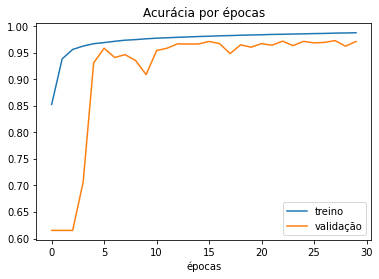

In [13]:
tf.keras.backend.clear_session()
internal_saver = Saver(model, history, base_output_path)
internal_saver.save_metrics(metric_name)

saved to: ..\imagens_cra\result\unet_multiclass_epoch_30_size_(128, 128)\loss_por_epocas


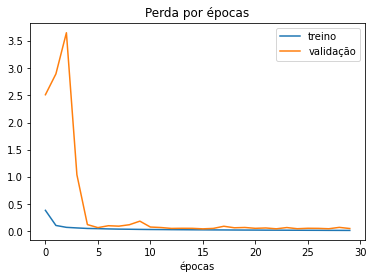

In [14]:
internal_saver.save_loss()



[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Write metrics to: ..\imagens_cra\result\unet_multiclass_epoch_30_size_(128, 128)\metrics.csv


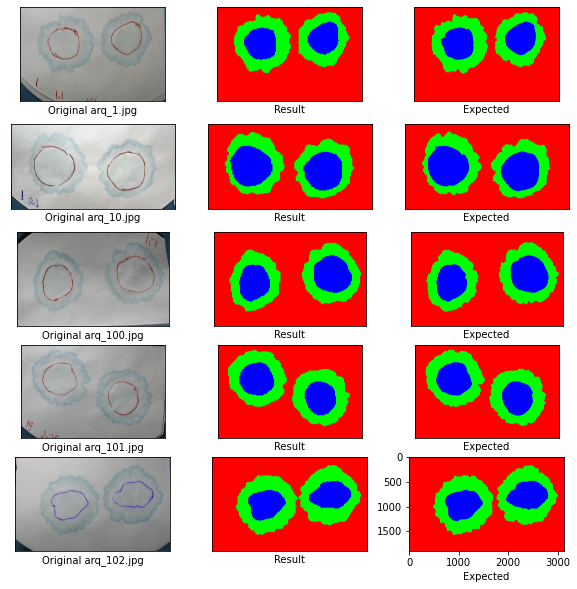

In [15]:
imgTester_metrics = [
    metric,
]
metric_name = "mean_iou_threshold"

dependencies = {
    metric_name: mean_iou_threshold,
}

imgUtil = ImgTesterV2(x_dir, y_dir, base_output_path, image_size, imgTester_metrics, dependencies)

test_v2(base_output_path, imgUtil, len(validImgs), 5)